In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm

# Define learning parameters

In [2]:
# learning parameters
batch_size = 512
epochs = 100
sample_size = 64 # fixed sample size for generator
nz = 128 # latent vector size
num_steps_train_discriminator = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare training dataset

In [3]:

transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

# Make input, output folders
!mkdir -p input
!mkdir -p outputs

# Load train data
train_data = datasets.MNIST(
    root='input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting input/data/MNIST/raw/train-images-idx3-ubyte.gz to input/data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting input/data/MNIST/raw/train-labels-idx1-ubyte.gz to input/data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting input/data/MNIST/raw/t10k-images-idx3-ubyte.gz to input/data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting input/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to input/data/MNIST/raw



# Generator

In [4]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

# Discriminator

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [6]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print('##### GENERATOR #####')
print(generator)
print('######################')
print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1

# Tools for training

In [7]:
# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

In [8]:
# loss function
criterion = nn.BCELoss() # Binary Cross Entropy loss

In [9]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

In [10]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)
# to create smooth real labels for discriminator loss
def label_smooth_real(size):
    data = torch.empty(size, 1).fill_(0.9)
    return data.to(device)

In [11]:
# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

In [12]:
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

In [13]:
# create the noise vector - fixed to track how GAN is trained.
noise = create_noise(sample_size, nz)

In [14]:
torch.manual_seed(7777)

def generator_loss(generator_output):
    ############ YOUR CODE HERE ##########
     gen_disc_output = discriminator(generator_output)
     loss = criterion(gen_disc_output, label_real(len(gen_disc_output)))
     return loss
    
    
    ######################################
    
def discriminator_loss(discriminator_output_fake, discriminator_output_true):
    ############ YOUR CODE HERE ##########
    loss_fake = criterion(discriminator_output_fake, label_fake(len(discriminator_output_fake)))
    loss_real = criterion(discriminator_output_true, label_smooth_real(len(discriminator_output_true)))
    
    return loss_fake, loss_real
    
    ######################################

# Q. Write training loop

118it [00:59,  1.98it/s]


Epoch 1 of 100
Generator loss: 1.68860297, Discriminator loss: 0.93090068


118it [01:04,  1.84it/s]


Epoch 2 of 100
Generator loss: 1.74589173, Discriminator loss: 1.18222717


118it [00:55,  2.13it/s]


Epoch 3 of 100
Generator loss: 5.72224485, Discriminator loss: 0.90102742


118it [00:57,  2.07it/s]


Epoch 4 of 100
Generator loss: 9.05329963, Discriminator loss: 0.36820529


118it [01:00,  1.96it/s]


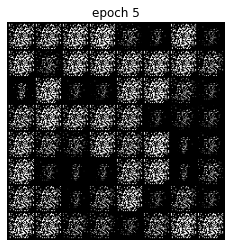

Epoch 5 of 100
Generator loss: 13.68311701, Discriminator loss: 0.50979104


118it [01:00,  1.95it/s]


Epoch 6 of 100
Generator loss: 11.68165546, Discriminator loss: 0.56474474


118it [00:57,  2.06it/s]


Epoch 7 of 100
Generator loss: 10.28905350, Discriminator loss: 0.35902004


118it [01:06,  1.77it/s]


Epoch 8 of 100
Generator loss: 14.09013321, Discriminator loss: 0.64634483


118it [00:54,  2.18it/s]


Epoch 9 of 100
Generator loss: 6.94542330, Discriminator loss: 0.51181842


118it [00:54,  2.18it/s]


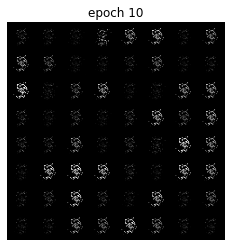

Epoch 10 of 100
Generator loss: 6.23230478, Discriminator loss: 0.60926230


118it [00:55,  2.12it/s]


Epoch 11 of 100
Generator loss: 5.65696986, Discriminator loss: 0.68048612


118it [00:55,  2.14it/s]


Epoch 12 of 100
Generator loss: 3.61018820, Discriminator loss: 0.80130637


118it [00:54,  2.15it/s]


Epoch 13 of 100
Generator loss: 3.58865518, Discriminator loss: 0.79440797


118it [00:54,  2.16it/s]


Epoch 14 of 100
Generator loss: 4.04266153, Discriminator loss: 0.81678766


118it [00:54,  2.16it/s]


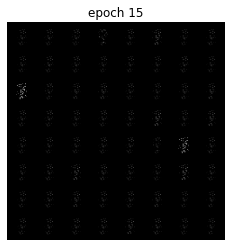

Epoch 15 of 100
Generator loss: 3.17280464, Discriminator loss: 0.83124241


118it [00:55,  2.14it/s]


Epoch 16 of 100
Generator loss: 3.18527632, Discriminator loss: 0.81416208


118it [00:55,  2.11it/s]


Epoch 17 of 100
Generator loss: 3.34406185, Discriminator loss: 0.82443964


118it [00:56,  2.08it/s]


Epoch 18 of 100
Generator loss: 4.68748365, Discriminator loss: 0.64378336


118it [00:54,  2.15it/s]


Epoch 19 of 100
Generator loss: 4.01219391, Discriminator loss: 0.62849232


118it [00:54,  2.17it/s]


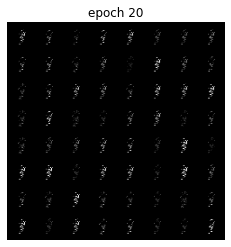

Epoch 20 of 100
Generator loss: 5.37207892, Discriminator loss: 0.58378941


118it [00:55,  2.13it/s]


Epoch 21 of 100
Generator loss: 4.88949530, Discriminator loss: 0.54496043


118it [00:55,  2.13it/s]


Epoch 22 of 100
Generator loss: 4.35649342, Discriminator loss: 0.58073739


118it [00:54,  2.18it/s]


Epoch 23 of 100
Generator loss: 4.58231304, Discriminator loss: 0.53288604


118it [00:54,  2.16it/s]


Epoch 24 of 100
Generator loss: 4.48814905, Discriminator loss: 0.62288951


118it [00:54,  2.16it/s]


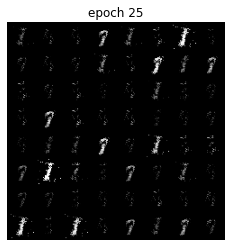

Epoch 25 of 100
Generator loss: 4.14459718, Discriminator loss: 0.65929386


118it [00:55,  2.14it/s]


Epoch 26 of 100
Generator loss: 4.12780881, Discriminator loss: 0.67463473


118it [00:55,  2.13it/s]


Epoch 27 of 100
Generator loss: 3.99217496, Discriminator loss: 0.67607597


118it [00:54,  2.17it/s]


Epoch 28 of 100
Generator loss: 4.33138231, Discriminator loss: 0.65857983


118it [00:54,  2.17it/s]


Epoch 29 of 100
Generator loss: 4.11594564, Discriminator loss: 0.62582568


118it [00:53,  2.19it/s]


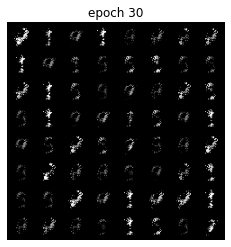

Epoch 30 of 100
Generator loss: 4.07256026, Discriminator loss: 0.66113406


118it [00:55,  2.12it/s]


Epoch 31 of 100
Generator loss: 4.49922783, Discriminator loss: 0.59891412


118it [00:55,  2.12it/s]


Epoch 32 of 100
Generator loss: 4.46930370, Discriminator loss: 0.62311005


118it [00:54,  2.15it/s]


Epoch 33 of 100
Generator loss: 4.20540897, Discriminator loss: 0.66698874


118it [00:54,  2.16it/s]


Epoch 34 of 100
Generator loss: 4.21051811, Discriminator loss: 0.60696199


118it [00:54,  2.16it/s]


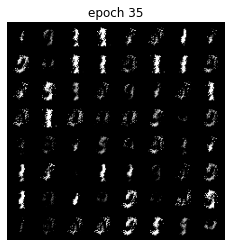

Epoch 35 of 100
Generator loss: 3.92131515, Discriminator loss: 0.71459388


118it [00:56,  2.10it/s]


Epoch 36 of 100
Generator loss: 3.93237040, Discriminator loss: 0.66059417


118it [00:54,  2.16it/s]


Epoch 37 of 100
Generator loss: 3.95318669, Discriminator loss: 0.63927598


118it [00:53,  2.19it/s]


Epoch 38 of 100
Generator loss: 4.08139009, Discriminator loss: 0.66104961


118it [00:54,  2.17it/s]


Epoch 39 of 100
Generator loss: 3.76025772, Discriminator loss: 0.69854645


118it [00:54,  2.16it/s]


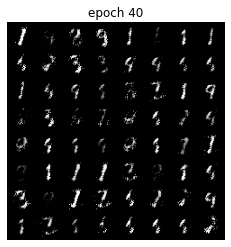

Epoch 40 of 100
Generator loss: 3.91844805, Discriminator loss: 0.66623520


118it [00:55,  2.12it/s]


Epoch 41 of 100
Generator loss: 3.48545150, Discriminator loss: 0.71041265


118it [00:54,  2.17it/s]


Epoch 42 of 100
Generator loss: 3.50048866, Discriminator loss: 0.75037332


118it [00:54,  2.15it/s]


Epoch 43 of 100
Generator loss: 3.53317160, Discriminator loss: 0.63305928


118it [00:54,  2.15it/s]


Epoch 44 of 100
Generator loss: 3.53758690, Discriminator loss: 0.63880758


118it [00:55,  2.13it/s]


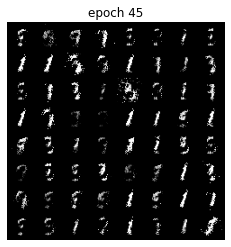

Epoch 45 of 100
Generator loss: 3.98811168, Discriminator loss: 0.62641973


118it [00:55,  2.11it/s]


Epoch 46 of 100
Generator loss: 4.15386509, Discriminator loss: 0.70082912


118it [00:55,  2.11it/s]


Epoch 47 of 100
Generator loss: 3.74384540, Discriminator loss: 0.71929185


118it [00:56,  2.10it/s]


Epoch 48 of 100
Generator loss: 3.80150799, Discriminator loss: 0.66748030


118it [00:56,  2.09it/s]


Epoch 49 of 100
Generator loss: 3.84131747, Discriminator loss: 0.64510935


118it [00:56,  2.07it/s]


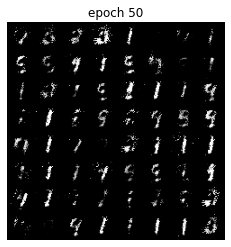

Epoch 50 of 100
Generator loss: 3.52433466, Discriminator loss: 0.73473762


118it [00:57,  2.07it/s]


Epoch 51 of 100
Generator loss: 3.57912266, Discriminator loss: 0.72167004


118it [00:56,  2.08it/s]


Epoch 52 of 100
Generator loss: 3.48284368, Discriminator loss: 0.74690060


118it [00:56,  2.09it/s]


Epoch 53 of 100
Generator loss: 3.49498017, Discriminator loss: 0.71605806


118it [00:56,  2.09it/s]


Epoch 54 of 100
Generator loss: 3.49210775, Discriminator loss: 0.72372956


118it [00:56,  2.08it/s]


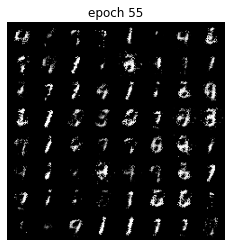

Epoch 55 of 100
Generator loss: 3.55665873, Discriminator loss: 0.73048288


118it [00:56,  2.10it/s]


Epoch 56 of 100
Generator loss: 3.47520982, Discriminator loss: 0.78769018


118it [00:55,  2.12it/s]


Epoch 57 of 100
Generator loss: 3.25265152, Discriminator loss: 0.75392305


118it [00:56,  2.10it/s]


Epoch 58 of 100
Generator loss: 3.01097023, Discriminator loss: 0.74705571


118it [00:55,  2.11it/s]


Epoch 59 of 100
Generator loss: 3.21712879, Discriminator loss: 0.72720512


118it [00:57,  2.07it/s]


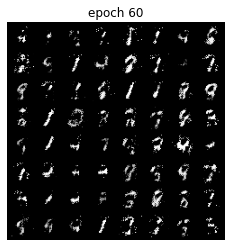

Epoch 60 of 100
Generator loss: 3.12673275, Discriminator loss: 0.78873570


118it [00:56,  2.09it/s]


Epoch 61 of 100
Generator loss: 3.17384372, Discriminator loss: 0.81125974


118it [00:56,  2.10it/s]


Epoch 62 of 100
Generator loss: 3.05362217, Discriminator loss: 0.77261731


118it [00:56,  2.10it/s]


Epoch 63 of 100
Generator loss: 3.04328561, Discriminator loss: 0.78657285


118it [00:57,  2.06it/s]


Epoch 64 of 100
Generator loss: 2.88423218, Discriminator loss: 0.80643065


118it [00:56,  2.10it/s]


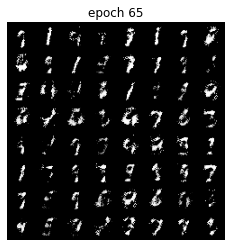

Epoch 65 of 100
Generator loss: 2.86599853, Discriminator loss: 0.78959152


118it [00:54,  2.17it/s]


Epoch 66 of 100
Generator loss: 2.69406314, Discriminator loss: 0.81418579


118it [00:54,  2.16it/s]


Epoch 67 of 100
Generator loss: 2.66322680, Discriminator loss: 0.82556966


118it [00:54,  2.15it/s]


Epoch 68 of 100
Generator loss: 2.62311368, Discriminator loss: 0.81257664


118it [00:55,  2.12it/s]


Epoch 69 of 100
Generator loss: 2.87645762, Discriminator loss: 0.78891619


118it [00:56,  2.09it/s]


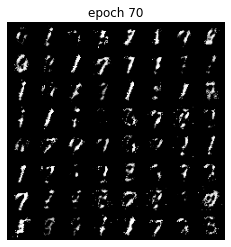

Epoch 70 of 100
Generator loss: 2.82704104, Discriminator loss: 0.81514496


118it [00:56,  2.08it/s]


Epoch 71 of 100
Generator loss: 2.59539862, Discriminator loss: 0.85371640


118it [00:56,  2.09it/s]


Epoch 72 of 100
Generator loss: 2.57316130, Discriminator loss: 0.82032773


118it [00:56,  2.08it/s]


Epoch 73 of 100
Generator loss: 2.60731294, Discriminator loss: 0.83418541


118it [00:57,  2.06it/s]


Epoch 74 of 100
Generator loss: 2.74898264, Discriminator loss: 0.82105515


118it [00:57,  2.06it/s]


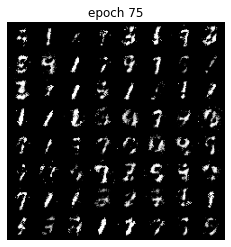

Epoch 75 of 100
Generator loss: 2.54003457, Discriminator loss: 0.87802796


118it [00:56,  2.11it/s]


Epoch 76 of 100
Generator loss: 2.49764390, Discriminator loss: 0.84336429


118it [00:56,  2.08it/s]


Epoch 77 of 100
Generator loss: 2.73693670, Discriminator loss: 0.85199286


118it [00:56,  2.07it/s]


Epoch 78 of 100
Generator loss: 2.53656440, Discriminator loss: 0.88124036


118it [00:58,  2.03it/s]


Epoch 79 of 100
Generator loss: 2.46982985, Discriminator loss: 0.90221100


118it [00:57,  2.06it/s]


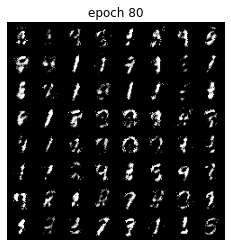

Epoch 80 of 100
Generator loss: 2.45790276, Discriminator loss: 0.91105052


118it [00:56,  2.07it/s]


Epoch 81 of 100
Generator loss: 2.47357464, Discriminator loss: 0.89101663


118it [00:57,  2.06it/s]


Epoch 82 of 100
Generator loss: 2.42095640, Discriminator loss: 0.89820770


118it [00:58,  2.03it/s]


Epoch 83 of 100
Generator loss: 2.54782922, Discriminator loss: 0.85849545


118it [00:57,  2.06it/s]


Epoch 84 of 100
Generator loss: 2.46841861, Discriminator loss: 0.88727742


118it [00:54,  2.15it/s]


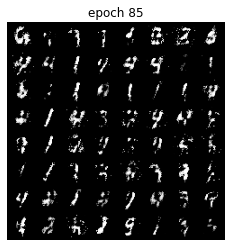

Epoch 85 of 100
Generator loss: 2.29417940, Discriminator loss: 0.92236580


118it [00:54,  2.15it/s]


Epoch 86 of 100
Generator loss: 2.33622188, Discriminator loss: 0.89861992


118it [00:54,  2.15it/s]


Epoch 87 of 100
Generator loss: 2.35583283, Discriminator loss: 0.88568129


118it [00:57,  2.06it/s]


Epoch 88 of 100
Generator loss: 2.40864695, Discriminator loss: 0.91539556


118it [00:57,  2.07it/s]


Epoch 89 of 100
Generator loss: 2.36744905, Discriminator loss: 0.90520724


118it [00:56,  2.09it/s]


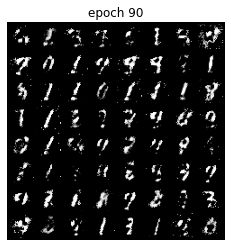

Epoch 90 of 100
Generator loss: 2.36433524, Discriminator loss: 0.89534650


118it [00:56,  2.09it/s]


Epoch 91 of 100
Generator loss: 2.38710025, Discriminator loss: 0.91418711


118it [00:56,  2.07it/s]


Epoch 92 of 100
Generator loss: 2.41086282, Discriminator loss: 0.93433148


118it [00:56,  2.10it/s]


Epoch 93 of 100
Generator loss: 2.04621203, Discriminator loss: 0.96372383


118it [00:56,  2.09it/s]


Epoch 94 of 100
Generator loss: 2.23122466, Discriminator loss: 0.91808056


118it [00:56,  2.10it/s]


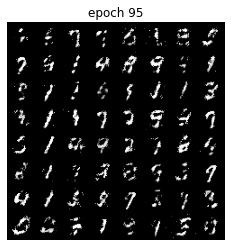

Epoch 95 of 100
Generator loss: 2.26023518, Discriminator loss: 0.91894494


118it [00:56,  2.07it/s]


Epoch 96 of 100
Generator loss: 2.19933763, Discriminator loss: 0.94603954


118it [00:57,  2.06it/s]


Epoch 97 of 100
Generator loss: 2.17054313, Discriminator loss: 0.94434935


118it [00:57,  2.06it/s]


Epoch 98 of 100
Generator loss: 2.08218480, Discriminator loss: 0.95292551


118it [00:56,  2.09it/s]


Epoch 99 of 100
Generator loss: 2.07603812, Discriminator loss: 0.97741934


118it [00:56,  2.10it/s]


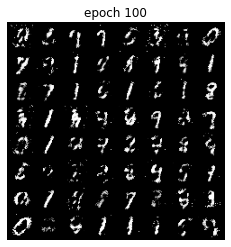

Epoch 100 of 100
Generator loss: 2.03496526, Discriminator loss: 0.95959450


In [15]:
for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        ############ YOUR CODE HERE ########## 

        #get the input to device
        data[0].to(device)

        # optimize discriminator
        loss_d_total = 0.0
        for _ in range(num_steps_train_discriminator):
          generator_output = generator(create_noise(len(data[0]), nz)).detach() 
          optim_d.zero_grad()
          
          # .detach() to ensure not part of the graph

          #get the preds from discriminator on fake and true data
          gen_disc_output = discriminator(generator_output)
          true_data_output = discriminator(data[0])

          #optimize the loss
          
          disc_loss_fake, disc_loss_real  = discriminator_loss(gen_disc_output, true_data_output) #between fake and true images
          disc_loss_fake.backward()
          disc_loss_real.backward()
          optim_d.step()

          #increase counter
          loss_d_total += (disc_loss_fake+disc_loss_real).detach().cpu().numpy()
    
        # optimize generator
        optim_g.zero_grad()
        generator_output = generator(create_noise(len(data[0]), nz))
        gen_loss = generator_loss(generator_output)
        gen_loss.backward()
        optim_g.step()

        loss_g += gen_loss.detach().cpu().numpy()
        loss_d += loss_d_total / num_steps_train_discriminator
        ######################################
    
    
    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()
    
    # make the images as grid
    generated_img = make_grid(generated_img)
    
    # visualize generated images
    if (epoch + 1) % 5 == 0:
        plt.imshow(generated_img.permute(1, 2, 0))
        plt.title(f'epoch {epoch+1}')
        plt.axis('off')
        plt.show()
    
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"outputs/gen_img{epoch+1}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    print(f"Epoch {epoch+1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

In [16]:
print('DONE TRAINING')
torch.save(generator.state_dict(), 'outputs/generator.pth')

DONE TRAINING


In [17]:
# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave('outputs/generator_images.gif', imgs)

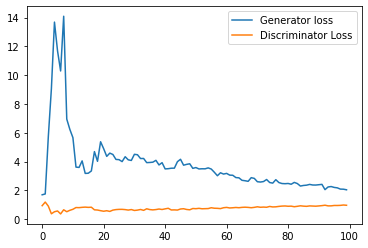

In [18]:
# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('outputs/loss.png')